# Downloading Data from Kaggle and unzipping





In [1]:
#!/bin/bash
!kaggle datasets download lexset/synthetic-asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet
License(s): copyright-authors
100% 6.58G/6.58G [05:54<00:00, 21.4MB/s]
100% 6.58G/6.58G [05:54<00:00, 19.9MB/s]


In [2]:
import zipfile
import os

# Replace 'dataset-name.zip' with the downloaded file name
dataset_zip = "synthetic-asl-alphabet.zip"

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("./synthetic-asl-alphabet")  # Extract files to 'asl_dataset' folder


In [ ]:
# !kaggle datasets download danrasband/asl-alphabet-test


Dataset URL: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
License(s): CC0-1.0
 45% 11.0M/24.3M [00:00<00:00, 78.8MB/s]
100% 24.3M/24.3M [00:00<00:00, 109MB/s] 


In [ ]:
# # Replace 'dataset-name.zip' with the downloaded file name
# dataset_zip = "asl-alphabet-test.zip"

# with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
#     zip_ref.extractall("./asl-alphabet-test")  # Extract files to 'asl_dataset' folder

# Importing Libararies and defining functions

In [3]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.8 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import cv2
import mediapipe as mp
import os
import pandas as pd
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [5]:
# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


In [6]:
def calculate_empty_tensor_percentage(asl_df):
    """
    Checks if any tensors in the 'tensor' column of asl_df are empty and calculates the percentage of them.

    Args:
        asl_df (pd.DataFrame): The DataFrame containing a 'tensor' column.

    Returns:
        float: Percentage of empty tensors in the DataFrame.
    """
    if "tensor" not in asl_df.columns:
        raise ValueError("The DataFrame does not contain a 'tensor' column.")

    # Check if each tensor is empty (all zeros or has no elements)
    empty_tensors = asl_df["tensor"].apply(lambda x: np.array(x).size == 0 or np.all(np.array(x) == 0))
    empty_count = empty_tensors.sum()
    total_count = len(asl_df)

    percentage_empty = (empty_count / total_count) * 100 if total_count > 0 else 0

    print(f"Empty tensors: {empty_count} / {total_count}")
    print(f"Percentage of empty tensors: {percentage_empty:.2f}%")

    return percentage_empty

In [7]:
def show_hand_landmarked_img(path):
  # Load image
  image_path = path
  image = cv2.imread(image_path)

  # Convert BGR image to RGB (Mediapipe expects RGB images)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Process the image with Mediapipe Hands
  with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
      results = hands.process(image_rgb)

      # Check if hand landmarks are detected
      if results.multi_hand_landmarks:
          for hand_landmarks in results.multi_hand_landmarks:
              # Draw landmarks on the original image
              mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

  # Save or display the result
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


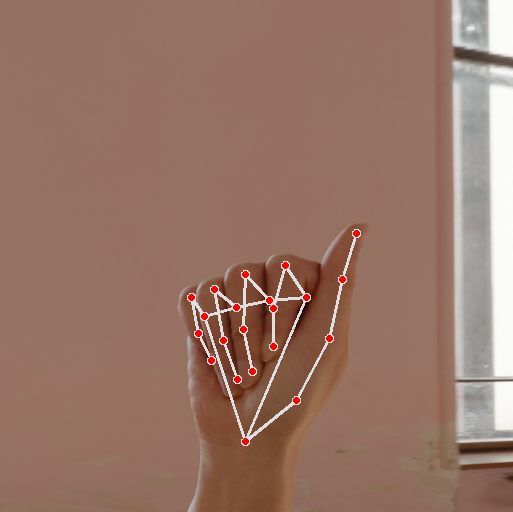

In [9]:
show_hand_landmarked_img('/content/synthetic-asl-alphabet/Train_Alphabet/A/0042513a-63c0-499f-a7f7-e6ee1266cb98.rgb_0000.png')

In [10]:
def get_hand_lanmark_coordinate_relative_to_wrist(path):
  # Load image
  image_path = path
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Process the image with Mediapipe Hands
  relative_landmarks_list = []
  with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
      results = hands.process(image_rgb)

      # Check if hand landmarks are detected
      if results.multi_hand_landmarks:
          for hand_landmarks in results.multi_hand_landmarks:
              # Get wrist coordinates (Landmark 0)
              wrist = hand_landmarks.landmark[0]
              wrist_x, wrist_y, wrist_z = wrist.x, wrist.y, wrist.z

              # Extract each landmark's coordinates relative to the wrist
              relative_landmarks = [
                  (round(lm.x - wrist_x, 3), round(lm.y - wrist_y, 3), round(lm.z - wrist_z, 3))
                  for lm in hand_landmarks.landmark
              ]
              relative_landmarks_list.append(relative_landmarks)

  return relative_landmarks_list


In [11]:
coordinate = get_hand_lanmark_coordinate_relative_to_wrist('/content/synthetic-asl-alphabet/Train_Alphabet/A/0042513a-63c0-499f-a7f7-e6ee1266cb98.rgb_0000.png')

In [12]:
def coordinate_to_tensor(coordinate):
  flat_list = [number for sublist in coordinate for tup in sublist for number in tup]
  # Convert to a TensorFlow tensor
  tensor = tf.constant(flat_list, dtype=tf.float32)  # Shape: (1, 21, 3)
  # Flatten and reshape to (63, 1)
  reshaped_tensor = tf.reshape(tensor, (63, 1))
  return reshaped_tensor

In [13]:
coordinate_to_tensor(coordinate)

<tf.Tensor: shape=(63, 1), dtype=float32, numpy=
array([[ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [ 0.1  ],
       [-0.08 ],
       [-0.072],
       [ 0.165],
       [-0.202],
       [-0.094],
       [ 0.191],
       [-0.317],
       [-0.112],
       [ 0.217],
       [-0.406],
       [-0.121],
       [ 0.12 ],
       [-0.282],
       [-0.015],
       [ 0.079],
       [-0.344],
       [-0.09 ],
       [ 0.055],
       [-0.26 ],
       [-0.134],
       [ 0.055],
       [-0.187],
       [-0.147],
       [ 0.048],
       [-0.275],
       [ 0.005],
       [ 0.001],
       [-0.326],
       [-0.089],
       [-0.002],
       [-0.219],
       [-0.12 ],
       [ 0.014],
       [-0.137],
       [-0.114],
       [-0.017],
       [-0.262],
       [ 0.009],
       [-0.06 ],
       [-0.298],
       [-0.08 ],
       [-0.042],
       [-0.198],
       [-0.084],
       [-0.015],
       [-0.122],
       [-0.057],
       [-0.079],
       [-0.245],
       [ 0.008],
       [-0.104],
       [-0.281],

In [30]:
def dataset_to_tensor(dataset_path, name):
  # Path to the dataset (change this to your dataset directory)
  dataset_path = dataset_path

  # Initialize an empty list to store data
  data = []

  # Loop through each subfolder (A, B, C, ...)
  num_images_per_folder = 900
  error_counter = 0
  for letter_folder in os.listdir(dataset_path):
      folder_path = os.path.join(dataset_path, letter_folder)
      if os.path.isdir(folder_path):  # Ensure it's a directory
          count = 0
          # print('ok')
          for image_file in os.listdir(folder_path):
              if count >= num_images_per_folder:
                  break
              else:
                  image_path = os.path.join(folder_path, image_file)
                  try:
                      coordinate = get_hand_lanmark_coordinate_relative_to_wrist(image_path)
                      tensor = coordinate_to_tensor(coordinate)  # Convert image to tensor
                      data.append((tensor, letter_folder))  # Append tensor and label (letter)
                      count += 1
                      # print(letter_folder)
                  except Exception as e:
                      # print(f"Error processing {image_path}: {e}")
                      error_counter += 1
  # Create a DataFrame
  asl_df = pd.DataFrame(data, columns=["tensor", "letter"])
  print(f"Number of errors: {error_counter}")
  # Save the DataFrame to a file if needed
  asl_df.to_pickle(f'{name}.pkl')  # Save as a pickle file

  # Optional: Print summary of the DataFrame


In [15]:
# It takes around 3 min and 30 secs for this cell to run on synthetic-asl-alphabet dataset
dataset_to_tensor('/content/synthetic-asl-alphabet/Test_Alphabet', 'test')

Number of errors: 372


In [ ]:
# It takes around 45 mins for this cell to run on synthetic-asl-alphabet dataset
dataset_to_tensor('/content/synthetic-asl-alphabet/Train_Alphabet', 'train')

In [24]:
df_train = pd.read_pickle('/content/train.pkl')
df_test = pd.read_pickle('/content/test.pkl')

In [29]:
df_train.head()

,tensor,letter
0,"((tf.Tensor(0.0, shape=(), dtype=float32)), (t...",C
1,"((tf.Tensor(0.0, shape=(), dtype=float32)), (t...",C
2,"((tf.Tensor(0.0, shape=(), dtype=float32)), (t...",C
3,"((tf.Tensor(0.0, shape=(), dtype=float32)), (t...",C
4,"((tf.Tensor(0.0, shape=(), dtype=float32)), (t...",C


# Tensors validation check


In [26]:
# Check if the length of every tensor in the 'tensor' column is 63
all_tensors_valid = df_test['tensor'].apply(lambda x: len(x) == 63).all()

if all_tensors_valid:
    print("All tensors have a length of 63.")
else:
    print("Not all tensors have a length of 63.")
    # Filter the dataframe to include only rows where the length of the tensor is 63
    df_test = df_test[df_test['tensor'].apply(len) == 63]



All tensors have a length of 63.


In [32]:
# Assuming df_train is your DataFrame containing 'tensor' and 'letter' columns
# Convert 'tensor' column to a NumPy array
X = np.array([tf.convert_to_tensor(tensor, dtype=tf.float32).numpy() for tensor in df_train['tensor'] if tensor.shape == (63, 1)] )

# Encode labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['letter'])

# Ensure y is a NumPy array of integers
y = np.array(y, dtype=np.int32)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),  # Input shape matches tensor shape
    layers.Flatten(),  # Flatten the input if it has more than 1 dimension
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model and label encoder
model.save('tensor_letter_model.h5')
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# To predict later, load the model and label encoder
# model = tf.keras.models.load_model('tensor_letter_model.h5')
# with open('label_encoder.pkl', 'rb') as f:
#     label_encoder = pickle.load(f)


Epoch 1/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3675 - loss: 2.3320 - val_accuracy: 0.8894 - val_loss: 0.6132
Epoch 2/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9124 - loss: 0.4553 - val_accuracy: 0.9406 - val_loss: 0.2796
Epoch 3/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9546 - loss: 0.2233 - val_accuracy: 0.9593 - val_loss: 0.2011
Epoch 4/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9674 - loss: 0.1701 - val_accuracy: 0.9677 - val_loss: 0.1711
Epoch 5/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9708 - loss: 0.1375 - val_accuracy: 0.9689 - val_loss: 0.1607
Epoch 6/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9736 - loss: 0.1249 - val_accuracy: 0.9739 - val_loss: 0.1412
Epoch 7/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9796 - loss: 0.1057 - val_accuracy: 0.9730 - val_loss: 0.1421
Epoch 8/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0907 - val_accuracy: 0.

Validation Loss: 0.1122303307056427, Validation Accuracy: 0.9810914397239685


In [38]:
coordinate = get_hand_lanmark_coordinate_relative_to_wrist("/content/synthetic-asl-alphabet/Test_Alphabet/T/00f3b838-18df-4dcc-97ac-37f5a739c365.rgb_0000.png")
tensor = coordinate_to_tensor(coordinate)
# Reshape the tensor to (1, 63, 1) to match the model's input shape
reshaped_tensor = tf.reshape(tensor, (1, 63, 1))
predictions = model.predict(reshaped_tensor)  # This will return probabilities for each class
predicted_label_index = np.argmax(predictions, axis=1)  # Get the class index with the highest probability
predicted_label = label_encoder.inverse_transform(predicted_label_index)  # Decode to the original label
print(f"Predicted Label: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Label: T


In [39]:
# Prepare test data
X_test, y_test = df_test['tensor'].values, df_test['letter'].values
X_test = np.array([tf.convert_to_tensor(tensor, dtype=tf.float32).numpy() for tensor in X_test])

# Predict on the test set
predictions = model.predict(X_test)  # Shape: (num_samples, num_classes)
predicted_indices = np.argmax(predictions, axis=1)  # Get class indices
predicted_labels = label_encoder.inverse_transform(predicted_indices)  # Decode to original labels

# Evaluate accuracy
print(classification_report(df_test['letter'], predicted_labels))

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           A       1.00      0.97      0.98        92
           B       1.00      0.99      0.99        90
           C       1.00      1.00      1.00        92
           D       0.97      0.93      0.95        82
           E       0.99      0.96      0.97        75
           F       1.00      0.99      0.99        91
           G       1.00      0.98      0.99        98
           H       1.00      1.00      1.00        97
           I       0.98      1.00      0.99        91
           J       0.99      0.99      0.99        91
           K       1.00      0.97      0.98        92
           L       0.99      1.00      0.99        93
           M       0.95      0.98      0.97        85
           N       0.98      1.00      0.99        93
           O       0.99      1.00      0.99        96
           P       0.98      1.00      0.99        91
           Q       0.99      0.99      0.9